In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [123]:
data_path = './data/'
df_data = pd.read_csv(data_path + 'data_processed.csv')
df_data['TOKENS'] = df_data['CLEAN_TEXT'].apply(nltk.word_tokenize)
df_data_genRe = df_data[['TOKENS', 'GEN_RE']]
df_data_30Re = df_data[['TOKENS', '30_RE']]

In [124]:
w2v = KeyedVectors.load_word2vec_format("PubMed-and-PMC-w2v.bin", binary=True)

In [125]:
pos_genRe_idx = np.where((df_data['GEN_RE'] == 1))[0]
neg_genRe_idx = np.where((df_data['GEN_RE'] == 0))[0]
pos_30Re_idx = np.where((df_data['30_RE'] == 1))[0]
neg_30Re_idx = np.where((df_data['30_RE'] == 0))[0]

In [126]:
def vectorize(tokens):
    vectors = [w2v[token] if token in w2v else np.random.uniform(-1, 1, (200,)).astype(np.float32) 
               for token in tokens]
    if len(vectors) == 0:
        return np.zeros(200)
    return np.mean(vectors, axis=0)

In [127]:
def generate_dataset(df_data, pos_idx, neg_idx, re_type, oversample=False):
    if oversample:
        num_neg = len(neg_idx)
        pos_idx_sample = np.random.choice(pos_idx, size=num_neg, replace=True)
        all_idx = neg_idx.tolist() + pos_idx_sample.tolist()
    else:
        num_pos = len(pos_idx)
        neg_idx_sample = np.random.choice(neg_idx, size=num_pos, replace=False)
        all_idx = pos_idx.tolist() + neg_idx_sample.tolist() 
    tokens_all = df_data.iloc[all_idx]['TOKENS'].tolist()
    labels = df_data.iloc[all_idx][re_type].tolist()
    vectors_all = np.array([vectorize(tokens) for tokens in tokens_all])
    return vectors_all, labels, neg_idx_sample


In [128]:
def augment_training_data(x_train, y_train, df_data, neg_idx_sample, re_type):
    num_neg = len(x_train) // 2
    add_neg_idx = np.random.choice(neg_idx_sample, size=min(num_neg, len(neg_idx_sample)), replace=False)
    add_x_neg = np.array([vectorize(df_data.iloc[idx]['TOKENS']) for idx in add_neg_idx])
    add_y_neg = df_data.iloc[add_neg_idx][re_type].tolist()

    pos_idx = [i for i, y in enumerate(y_train) if y == 1]
    add_x_pos = np.array([x_train[i] for i in pos_idx])
    add_y_pos = [y_train[i] for i in pos_idx]

    x_train = np.concatenate([x_train, add_x_neg, add_x_pos], axis=0)
    y_train = y_train + add_y_neg + add_y_pos
    return x_train, y_train

In [129]:
vectors_all_genRe, labels_genRe, neg_idx_genRe = generate_dataset(df_data_genRe, pos_genRe_idx, neg_genRe_idx, 'GEN_RE', oversample=False)
x_train_genRe, x_test_genRe, y_train_genRe, y_test_genRe = train_test_split(vectors_all_genRe, labels_genRe, test_size=0.1, shuffle=True)
x_train_genRe, x_val_genRe, y_train_genRe, y_val_genRe = train_test_split(x_train_genRe, y_train_genRe, test_size=0.1, shuffle=True)

x_train_genRe, y_train_genRe = augment_training_data(x_train_genRe, y_train_genRe, df_data_genRe, neg_idx_genRe, 'GEN_RE')
print(f"[GEN_RE] Positive ratio in training set: {np.mean(y_train_genRe):.2f}")

rf_model_genRe = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_genRe.fit(x_train_genRe, y_train_genRe)

val_preds_genRe = rf_model_genRe.predict(x_val_genRe)
val_acc_genRe = accuracy_score(y_val_genRe, val_preds_genRe)
val_f1_genRe = f1_score(y_val_genRe, val_preds_genRe)
print(f"Validation - Accuracy: {val_acc_genRe:.4f}, F1 Score: {val_f1_genRe:.4f}")

[GEN_RE] Positive ratio in training set: 0.50
Validation - Accuracy: 0.6787, F1 Score: 0.5859


In [130]:
test_preds_genRe = rf_model_genRe.predict(x_test_genRe)
acc_genRe = accuracy_score(y_test_genRe, test_preds_genRe)
prec_genRe = precision_score(y_test_genRe, test_preds_genRe)
rec_genRe = recall_score(y_test_genRe, test_preds_genRe)
f1_genRe = f1_score(y_test_genRe, test_preds_genRe)
print('Test Results:')
print(f'Test Accuracy: {acc_genRe:.4f}')
print(f'Test Precision: {prec_genRe:.4f}')
print(f'Test Recall: {rec_genRe:.4f}')
print(f'Test F1 Score: {f1_genRe:.4f}\n')

Test Results:
Test Accuracy: 0.6615
Test Precision: 0.7644
Test Recall: 0.4791
Test F1 Score: 0.5890


In [131]:
y_probs_genRe = rf_model_genRe.predict_proba(x_test_genRe)[:, 1]
fpr_genRe, tpr_genRe, _ = roc_curve(y_test_genRe, y_probs_genRe)
roc_auc_genRe = auc(fpr_genRe, tpr_genRe)

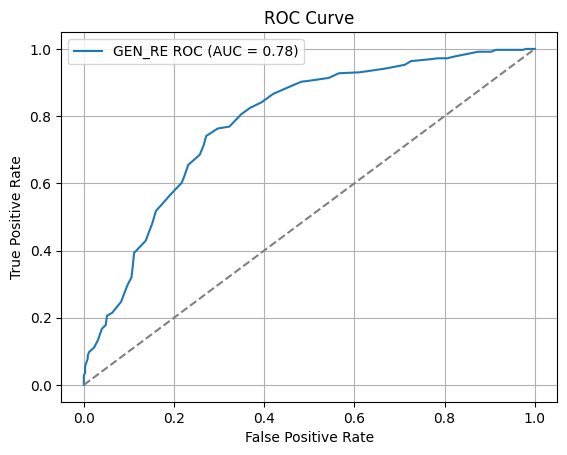

In [132]:
plt.figure()
plt.plot(fpr_genRe, tpr_genRe, label=f'GEN_RE ROC (AUC = {roc_auc_genRe:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

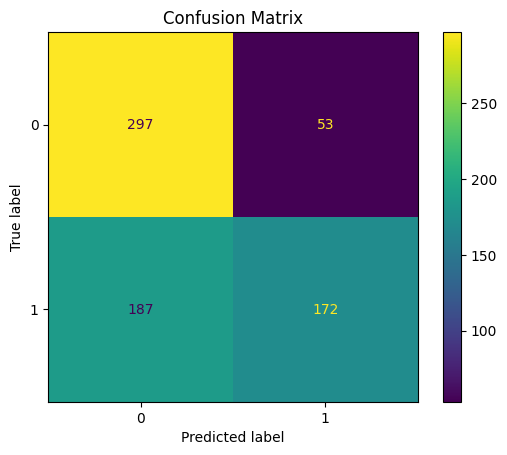

In [133]:
cm_genRe = confusion_matrix(y_test_genRe, test_preds_genRe)
disp_genRe = ConfusionMatrixDisplay(confusion_matrix=cm_genRe)
disp_genRe.plot()
plt.title("Confusion Matrix")
plt.show()

In [134]:
vectors_all_30Re, labels_30Re, neg_idx_sample = generate_dataset(df_data_30Re, pos_30Re_idx, neg_30Re_idx, '30_RE', oversample=False)
x_train_30Re, x_test_30Re, y_train_30Re, y_test_30Re = train_test_split(vectors_all_30Re, labels_30Re, test_size=0.1, shuffle=True)
x_train_30Re, x_val_30Re, y_train_30Re, y_val_30Re = train_test_split(x_train_30Re, y_train_30Re, test_size=0.1, shuffle=True)

x_train_30Re, y_train_30Re = augment_training_data(x_train_30Re, y_train_30Re, df_data_30Re, neg_idx_sample, '30_RE')
print(f"[30_RE] Positive ratio in training set: {np.mean(y_train_30Re):.2f}")

[30_RE] Positive ratio in training set: 0.49


In [135]:
rf_model_30Re = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_30Re.fit(x_train_30Re, y_train_30Re)

RandomForestClassifier(random_state=42)

In [136]:
val_preds_30Re = rf_model_30Re.predict(x_val_30Re)
val_acc_30Re = accuracy_score(y_val_30Re, val_preds_30Re)
val_f1_30Re = f1_score(y_val_30Re, val_preds_30Re)
print(f"30_RE Validation - Accuracy: {val_acc_30Re:.4f}, F1 Score: {val_f1_30Re:.4f}")

30_RE Validation - Accuracy: 0.6437, F1 Score: 0.5811


In [137]:
test_preds_30Re = rf_model_30Re.predict(x_test_30Re)
acc_30Re = accuracy_score(y_test_30Re, test_preds_30Re)
prec_30Re = precision_score(y_test_30Re, test_preds_30Re)
rec_30Re = recall_score(y_test_30Re, test_preds_30Re)
f1_30Re = f1_score(y_test_30Re, test_preds_30Re)
print('30_RE Test Results:')
print(f'Test Accuracy: {acc_30Re:.4f}')
print(f'Test Precision: {prec_30Re:.4f}')
print(f'Test Recall: {rec_30Re:.4f}')
print(f'Test F1 Score: {f1_30Re:.4f}')


30_RE Test Results:
Test Accuracy: 0.6684
Test Precision: 0.8545
Test Recall: 0.4563
Test F1 Score: 0.5949


In [138]:
y_probs_30Re = rf_model_30Re.predict_proba(x_test_30Re)[:, 1]
fpr_30Re, tpr_30Re, _ = roc_curve(y_test_30Re, y_probs_30Re)
roc_auc_30Re = auc(fpr_30Re, tpr_30Re)

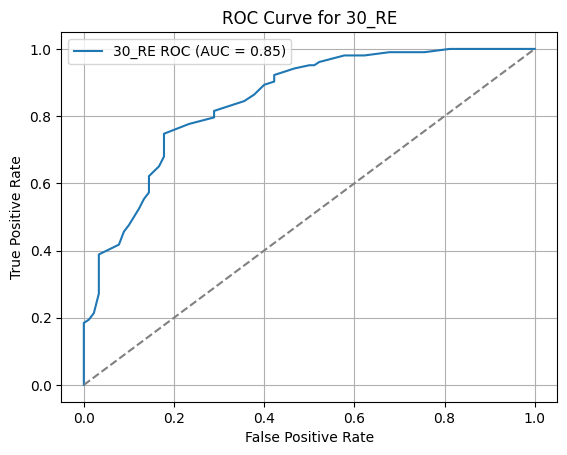

In [139]:
plt.figure()
plt.plot(fpr_30Re, tpr_30Re, label=f'30_RE ROC (AUC = {roc_auc_30Re:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 30_RE')
plt.legend()
plt.grid(True)
plt.show()

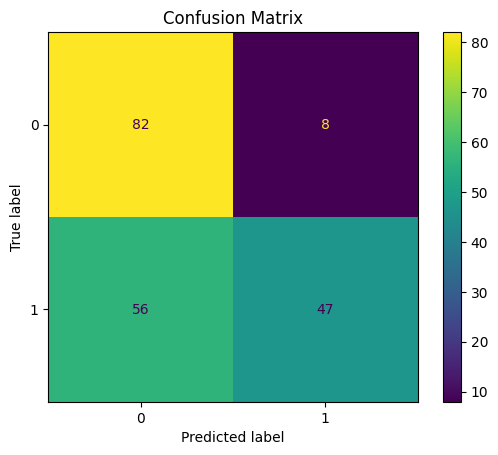

In [140]:
cm_30Re = confusion_matrix(y_test_30Re, test_preds_30Re)
disp_30Re = ConfusionMatrixDisplay(confusion_matrix=cm_30Re)
disp_30Re.plot()
plt.title("Confusion Matrix")
plt.show()